# Archive - Dont touch


In [ ]:
#  for band in relavant_band_real:
#             band = band.astype(np.float32)
#             median_filtered = cv2.medianBlur(band, ksize=kernel_size)
#             smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
#             wiener_filtered = wiener_filter(band, kernel_size=kernel_size)
#             median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=kernel_size)

#             filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

#             for filter_img in filters:
#                 filtered_clusters = kmeans(filter_img, n_clusters=3, display=False)
#                 largest_noise_clus = None
#                 max_noise = -1e32
#                 for clus in list(np.unique(filtered_clusters)):
#                     internal_mask = (filtered_clusters == clus).astype(np.int8)
#                     noise = (band - filter_img) * internal_mask
#                     noise_range = noise.max() - noise.min()

#                     if (noise_range > max_noise):
#                         largest_noise_clus = clus

#                 assert largest_noise_clus != None
#                 final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

#         for band in relavant_band_imag:
#             band = band.astype(np.float32)
#             median_filtered = cv2.medianBlur(band, ksize=kernel_size)
#             smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
#             wiener_filtered = wiener_filter(band, kernel_size=3)
#             median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=3)

#             filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

#             for filter_img in filters:
#                 filtered_clusters = kmeans(filter_img, n_clusters=3, display=False)
#                 largest_noise_clus = None
#                 max_noise = -1e32
#                 for clus in list(np.unique(filtered_clusters)):
#                     internal_mask = (filtered_clusters == clus).astype(np.int8)
#                     noise = (band - filter_img) * internal_mask
#                     noise_range = noise.max() - noise.min()

#                     if (noise_range > max_noise):
#                         largest_noise_clus = clus

#                 assert largest_noise_clus != None
#                 final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

# Load Libraries

In [124]:
# Uncomment to install PyWavelets
# !pip3 install PyWavelets
# !pip3 install dtcwt

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from PIL import Image

# For semantic segmentation
import torch
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

from skimage import io, color, img_as_float
from scipy.ndimage import gaussian_filter

import pywt
import dtcwt

# Image Read

In [126]:
# read image of any format - png, bmp, jpg and return the rgb image as numpy array
# normalize the image to [0, 1] range
def read_img(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    img = img / 255.0
    return img

# Segmentation - KMeans and Semantic

In [127]:
def kmeans(img, n_clusters, display=False):
    data = img.reshape((-1, 1))
    H, W = img.shape

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    clusters = kmeans.fit_predict(data)
    clusters = clusters.reshape((H, W))

    if display:
        plt.imshow(clusters, cmap="Spectral")
        plt.title(f"Input Image Segmentation, n_clusters: {n_clusters}")
        plt.axis('off')
        plt.show()

    return clusters

In [128]:
# Semantic Segmentation of the image
def semantic_segmentation(img, n_clusters, display=False):

    # Load a pretrained DeepLabV3 model with ResNet-50 backbone
    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
    model.eval()  # Set the model to evaluation mode

    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the preprocessing
    input_tensor = preprocess(img).float()
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    with torch.no_grad():
        output = model(input_batch)["out"][0]  # Shape: [21, H, W] for 21 classes   

    # Get the predicted class for each pixel
    segmentation = torch.argmax(output, dim=0).byte().cpu().numpy()

    if display:
        plt.imshow(segmentation)
        plt.title("Segmentation Mask")
        plt.axis("off")
        plt.show()

    return segmentation # THINK: Is it too many clusters?

In [129]:
from skimage.morphology import opening, closing, disk
from skimage import io, color, img_as_float, morphology
from scipy.ndimage import gaussian_filter
from scipy import ndimage as ndi
def simple_segmentation(image, n_clusters=5, feature_space='rgb', spatial_weight=0.6, smoothing_sigma=1,display=False):
    """
    Perform simple image segmentation using K-means clustering.

    Parameters:
    - image: Input image as a NumPy array.
    - n_clusters: The desired number of clusters (segments).
    - feature_space: The color space to use ('rgb' or 'lab').

    Returns:
    - labels: A 2D array of the same height and width as the image, containing the segment labels.
    """
    # Convert image to float representation
    image = img_as_float(image)
    h, w, c = image.shape

    # Apply image smoothing to reduce noise
    smoothed_image = gaussian_filter(image, sigma=(smoothing_sigma, smoothing_sigma, 0))

    # Choose feature space
    if feature_space == 'lab':
        # Convert to Lab color space for better perceptual similarity
        image_feats = color.rgb2lab(smoothed_image)
    else:
        # Use RGB color space
        image_feats = smoothed_image

    # Reshape the image to a 2D array of pixels and color features
    X = image_feats.reshape((-1, c))

    # Perform K-means clustering
    print("Performing K-means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    # Reshape labels back to image dimensions
    labels = labels.reshape((h, w))

    # Apply improved morphological operations to clean up small regions
    selem = morphology.disk(5)
    labels_cleaned = np.zeros_like(labels)
    min_size = 500  # Adjust this value based on image size

    for i in range(n_clusters):
        mask = (labels == i).astype(np.bool_)
        mask_filled = ndi.binary_fill_holes(mask)
        mask_cleaned = morphology.remove_small_objects(mask_filled, min_size=min_size)
        mask_smooth = morphology.closing(mask_cleaned, selem)
        mask_smooth = morphology.opening(mask_smooth, selem)
        labels_cleaned[mask_smooth] = i

    if display:
        plt.imshow(labels_cleaned, cmap='tab20')
        plt.axis('off')
        plt.title('Segmentation Result')
        plt.show()

    return labels_cleaned


# Band Processing

In [130]:
# Performs Log Normalization and z-tranforms and clips data [-1, 2] range
def normalize_coeffs(bands):
    reals = []
    imags = []
    for band in range(bands.shape[-1]):
        real_coeffs = bands[:, :, band].real
        imag_coeffs = bands[:, :, band].imag

        # Normalize
        # Log (1+x) transform
        eps = 1e-8
        real_coeffs = np.log10((real_coeffs) + abs(real_coeffs.min()) + eps)
        imag_coeffs = np.log10((imag_coeffs) + abs(imag_coeffs.min()) + eps)

        # Z-Scaling
        real_coeffs = (real_coeffs - real_coeffs.mean()) / (real_coeffs.std() + 1e-8)
        imag_coeffs = (imag_coeffs - imag_coeffs.mean()) / (imag_coeffs.std() + 1e-8)

        reals.append(real_coeffs)
        imags.append(imag_coeffs)

    return np.asarray(reals), np.asarray(imags)

In [131]:
def display_wavelet_coeffs(reals, imags, display=False):
    # Clip the data to [-1, 2] range
    reals = np.clip(reals, -1, 2)
    imags = np.clip(imags, -1, 2)
    if display:
        plt.figure(figsize=(12, 4))
        for i, data in enumerate(zip(reals, imags)):
            real, imag = data

            plt.subplot(2, 6, i + 1)
            plt.imshow(real, cmap="Spectral")
            plt.title(f"Real, Band{i+1}")
            plt.axis('off')

            plt.subplot(2, 6, i + 7)
            plt.imshow(imag, cmap="Spectral")
            plt.title(f"Imag, Band{i+1}")
            plt.axis('off')

        plt.suptitle("Level 1, Real and Imaginary Bands 1-6")
        plt.show()

In [132]:
def get_patch_mean_variance(band, patch_size):
    H, W = band.shape
    patch_means = []
    for h in range(0, H, patch_size):
        for w in range(0, W, patch_size):
            patch = band[h:h+patch_size, w:w+patch_size]
            patch_means.append(np.mean(patch))

    var = np.var(patch_means)
    return var

In [133]:
def get_band_variance(mask, reals, imags, patch_size=16):
    real_var = []
    imag_var = []
    for real, imag in zip(reals, imags):
        # Real first
        band = mask * real
        real_var.append(get_patch_mean_variance(band, patch_size))
        
        # Imag
        band = mask * imag
        imag_var.append(get_patch_mean_variance(band, patch_size))

    return np.asarray(real_var), np.asarray(imag_var)

In [134]:
def compute_threshold_dynamic(real_coeffs, imag_coeffs):
    var_reals, var_imag = get_band_variance(np.ones_like(real_coeffs[0]), real_coeffs, imag_coeffs)
    var = np.concatenate((var_imag, var_reals))
    var.sort()

    return var[-5]

# Wavelets

In [135]:
# Return the coeffs of the DT-CWT transform
def wavelet_dtcwt(img):
    assert len(img.shape) == 2, "Not a grayscale image"

    # Initialize the DTCWT transform
    transform = dtcwt.Transform2d()

    # Perform the DTCWT on the image with only 1 level
    coeffs = transform.forward(img, nlevels=1)
    return coeffs.highpasses[0]


In [136]:
def wavelet_general(img, wavelet_type='haar'):

    if wavelet_type == 'dtcwt':
        return wavelet_dtcwt(img)

    LL, (LH, HL, HH) = pywt.dwt2(img, wavelet_type)
    print(LH.shape)
    H, W = LH.shape

    coeffs = np.zeros((H, W, 3))
    coeffs[:, :, 0] = LH
    coeffs[:, :, 1] = HL
    coeffs[:, :, 2] = HH

    return coeffs

# Noise Models


In [137]:
def noise_zero(img):
    return np.zeros_like(img)

# Noise Variance Method

In [138]:
def im2patch(im, pch_size, stride=1):
    '''
    Transform image to patches.
    Input:
        im: 3 x H x W or 1 X H x W image, numpy format
        pch_size: (int, int) tuple or integer
        stride: (int, int) tuple or integer
    '''
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size
    else:
        print('The input of pch_size must be a integer or a int tuple!')

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride
    else:
        print('The input of stride must be a integer or a int tuple!')


    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = np.zeros((C, pch_H*pch_W, num_pch), dtype=im.dtype)
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

In [139]:
def noise_estimate(im, pch_size=8):
    '''
    Implement of noise level estimation of the following paper:
    Chen G , Zhu F , Heng P A . An Efficient Statistical Method for Image Noise Level Estimation[C]// 2015 IEEE International Conference
    on Computer Vision (ICCV). IEEE Computer Society, 2015.
    Input:
        im: the noise image, H x W x 3 or H x W numpy tensor, range [0,1]
        pch_size: patch_size
    Output:
        noise_level: the estimated noise level
    '''

    if im.ndim == 3:
        im = im.transpose((2, 0, 1))
    else:
        im = np.expand_dims(im, axis=0)

    # image to patch
    pch = im2patch(im, pch_size, 3)  # C x pch_size x pch_size x num_pch tensor
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))  # d x num_pch matrix
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = np.matmul(X, X.transpose()) / num_pch
    sig_value, _ = np.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = np.mean(sig_value[:ii])
        if np.sum(sig_value[:ii]>tau) == np.sum(sig_value[:ii] < tau):
            return np.sqrt(tau)

# Filtering

In [140]:
# normalise the output between [0,1]
def small_median_filter_residue(band, kernel_size):
    median_blur = cv2.medianBlur(band, ksize=kernel_size)
    first_diff = band - median_blur
    second_diff = cv2.medianBlur(first_diff, ksize=kernel_size)
    band = band - second_diff
    band = (band - band.min()) / (band.max() - band.min())
    return band

In [141]:
def wiener_filter(band, kernel_size=3, noise_variance=0.1):
    local_mean = cv2.blur(band, (kernel_size, kernel_size))
    local_variance = cv2.blur((band - local_mean) ** 2, (kernel_size, kernel_size))
    wiener_filtered = local_mean + (local_variance - noise_variance) / (local_variance + 1e-8) * (band - local_mean)
    return np.clip(wiener_filtered, 0, 1)  # Clipping to avoid overflow

In [142]:
from skimage import restoration
from scipy.signal import convolve2d

# normalise the output between [0,1]
def wiener_filter_updated(img):
    psf = np.ones((5, 5)) / 25
    img = convolve2d(img, psf, 'same')
    rng = np.random.default_rng()
    img += 0.1 * img.std() * rng.standard_normal(img.shape)
    deconvolved_img = restoration.wiener(img, psf, 0.1)
    deconvolved_img = (deconvolved_img - deconvolved_img.min()) / (deconvolved_img.max() - deconvolved_img.min())
    return deconvolved_img

In [143]:
# normalise the output between [0,1]
def median_modified_wiener_filter(band, kernel_size=3, noise_variance=0.1):
    # Step 1: Apply median filter
    median_filtered = cv2.medianBlur(band, kernel_size)
    # Step 2: Apply Wiener filter to median-filtered band
    # wiener_filtered = wiener_filter(median_filtered, kernel_size, noise_variance)
    wiener_filtered = wiener_filter_updated(median_filtered)
    wiener_filtered = (wiener_filtered - wiener_filtered.min()) / (wiener_filtered.max() - wiener_filtered.min())
    return wiener_filtered

In [144]:
def get_mask_from_releavant_bands(bands, kernel_size, display=False):
    if len(bands) == 0:
        print("No bands available. Adjust threshold maybe.")
        return 0

    final_mask = np.zeros_like(bands[0])
    for band in bands:
        band = band.astype(np.float32)
        median_filtered = cv2.medianBlur(band, ksize=kernel_size)
        
        # normalise the output between [0,1]
        median_filtered = (median_filtered - median_filtered.min()) / (median_filtered.max() - median_filtered.min())

        smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
        # wiener_filtered = wiener_filter(band, kernel_size=kernel_size)
        wiener_filtered = wiener_filter_updated(band)
        median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=kernel_size)

        # filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]
        filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

        #display filtered images
        if display:
            plt.figure(figsize=(12, 4))
            for i, filter_img in enumerate(filters):
                filter_img_clipped = np.clip(filter_img, -1, 2)
                plt.subplot(1, 4, i + 1)
                plt.imshow(filter_img_clipped, cmap="Spectral")
                plt.title(f"Filter {i+1}")
                plt.axis('off')
                plt.colorbar()
            plt.suptitle("Filtered Images")
            plt.show()

        # noise estimate for the band 
        # largest_noise_estimate = noise_estimate(band, 8)

        avg_filter = np.zeros_like(median_filtered)
        for filter_img in filters:
            avg_filter += filter_img
        avg_filter /= len(filters)
        if display:
            avg_filter_clipped = np.clip(avg_filter, -1, 2)
            plt.imshow(avg_filter_clipped, cmap="Spectral")
            plt.title("Average Filter")
            plt.colorbar()
            plt.axis('off')
            plt.show()


        for filter_img in [avg_filter]:
            filtered_clusters = kmeans(filter_img, n_clusters=3, display=True)

            largest_noise_clus = None
            largest_noise_estimate = 1e-32
            # max_noise = -1e32
            for clus in list(np.unique(filtered_clusters)):
            #     internal_mask = (filtered_clusters == clus).astype(np.int8)
            #     noise = (band - filter_img) * internal_mask
            #     noise_range = noise.max() - noise.min()
                noise_est = noise_estimate(band, 8)
                if noise_est > largest_noise_estimate:
                    largest_noise_clus = clus
                    largest_noise_estimate = noise_est

            assert largest_noise_clus != None

            # display the lowest noise cluster
            if display:
                plt.imshow(filtered_clusters == largest_noise_clus)
                plt.title("Largest Noise Cluster")
                plt.colorbar()
                plt.axis('off')
                plt.show()

            final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

    return final_mask

# Wrapper Function

In [145]:
def detect_inpainting(file_path, wavelet_type, noise_func, patch_size=16, var_threshold='dynamic', kernel_size=3, display=False):
    # Read Image
    img = read_img(file_path)
    
    # Display Input Image
    if display:
        plt.imshow(img)
        plt.axis('off')
        plt.title("Input Image")
        plt.show()
        print("Image Shape ", img.shape)

    # Convert to grayscale
    gray_img = img.mean(axis=2)
    H, W = gray_img.shape

    # Display Gray Image
    if display:
        plt.imshow(gray_img, cmap="gray")
        plt.axis('off')
        plt.title("Gray Image")
        plt.show()

    # clusters = semantic_segmentation(img, n_clusters=1, display=True)
    clusters = simple_segmentation(img, n_clusters=4, feature_space='rgb', display=display, spatial_weight=0.9, smoothing_sigma=1)
    
    
    # TODO: Check if this is correct
    # We are W/2 and H/2 because the bands are of this size. But is this correct?
    clusters = clusters[::2, ::2]

    # Add Noise TODO: Check if this is the right place to add noise
    noise = noise_func(gray_img)
    gray_img += noise

    # DTCWT on grayscale image
    wavelet_coeffs = wavelet_general(gray_img, wavelet_type=wavelet_type) 
    print("Wavelet Coeffs Shape: ", wavelet_coeffs.shape)
    ##########################
    # IMPORTANT: wavelet_coeffs has to of the shape [H/2, W/2, bands]
    ##########################
    # assert wavelet_coeffs.shape == ((H+1)//2, (W+1)//2, 6), f"wavelet_coeffs is of shape: {wavelet_coeffs.shape}, but it's supposed to be {((H+1)//2, (W+1)//2, 6)}"

    # Normalize
    real_coeffs, imag_coeffs = normalize_coeffs(wavelet_coeffs)

    # Display Normalized and Clipped Wavelet Coefficients
    display_wavelet_coeffs(real_coeffs, imag_coeffs, display=display)

    final_mask = np.zeros_like(real_coeffs[0]) # TODO: Put correct shape here
    if var_threshold == 'dynamic':
        var_threshold = compute_threshold_dynamic(real_coeffs, imag_coeffs)

    print("Threhsold: ", var_threshold)

    for cluster in list(np.unique(clusters)):
        mask = (clusters == cluster).astype(np.int8)

        #pad the mask to make it equal to the size of the bands
        pad_x = (real_coeffs[0].shape[0] - mask.shape[0])
        pad_y = (real_coeffs[0].shape[1] - mask.shape[1])
        mask = np.pad(mask, ((pad_x//2, pad_x-(pad_x//2)), (pad_y//2, pad_y-(pad_y//2))), 'constant', constant_values=(0, 0))


        #display mask
        if display:
            plt.imshow(mask, cmap="gray")
            plt.axis('off')
            plt.title("Mask Image")
            plt.show()
        
        real_vars, imag_vars = get_band_variance(mask, real_coeffs, imag_coeffs, patch_size=patch_size)
        print("Real Vars: ", real_vars)
        print("Imag Vars: ", imag_vars)
        
        relavant_band_real = []
        relavant_band_imag = []

        print("Picked Bands:")
        for i in range(len(real_vars)):
            rvar, ivar = real_vars[i], imag_vars[i]

            if rvar >= var_threshold:
                relavant_band_real.append(mask * real_coeffs[i])
                print(f"Real {i+1}")

            if ivar >= var_threshold:
                relavant_band_imag.append(mask * imag_coeffs[i])
                print(f"Imag {i+1}")
                
        final_mask += get_mask_from_releavant_bands(relavant_band_real, kernel_size=kernel_size, display=display)
        final_mask += get_mask_from_releavant_bands(relavant_band_imag, kernel_size=kernel_size, display=display)

    if display:    
        plt.imshow(final_mask, cmap="gray")
        plt.axis('off')
        plt.title("Final Mask")
        plt.show()


    return final_mask

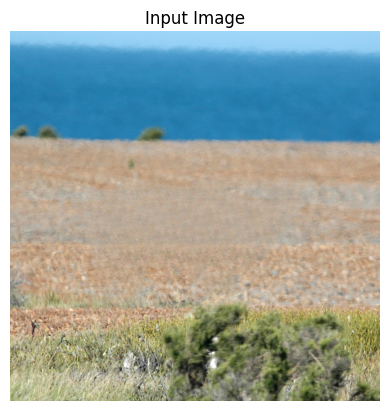

Image Shape  (1023, 1024, 3)


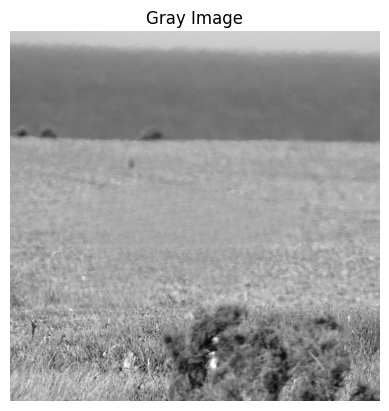

Performing K-means clustering...


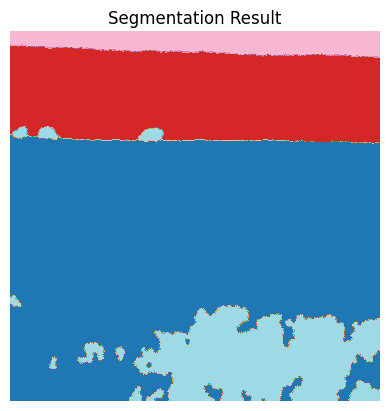

Wavelet Coeffs Shape:  (512, 512, 6)


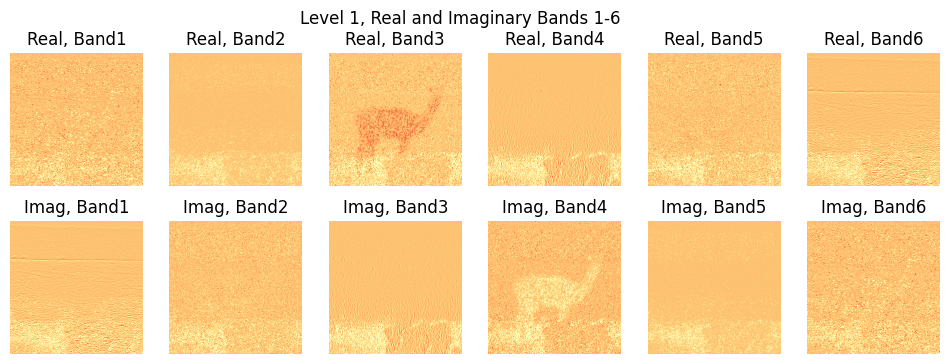

Threhsold:  0.003933763528226486


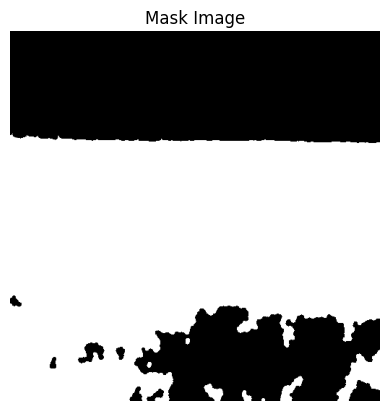

Real Vars:  [0.00030706 0.00080064 0.00347298 0.00164739 0.0010474  0.00071469]
Imag Vars:  [0.00090634 0.0010464  0.00175964 0.00508122 0.00091028 0.00043333]
Picked Bands:
Imag 4
No bands available. Adjust threshold maybe.


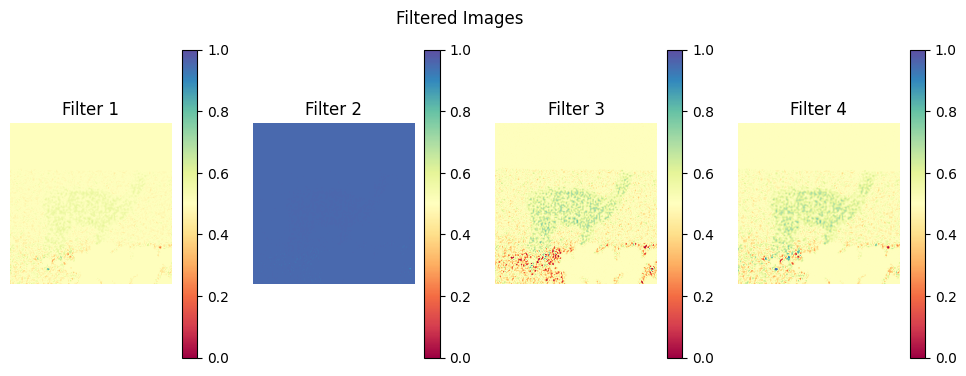

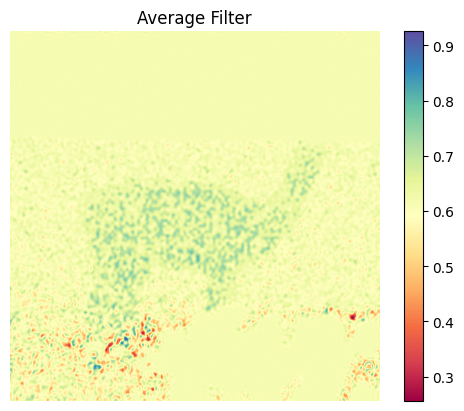

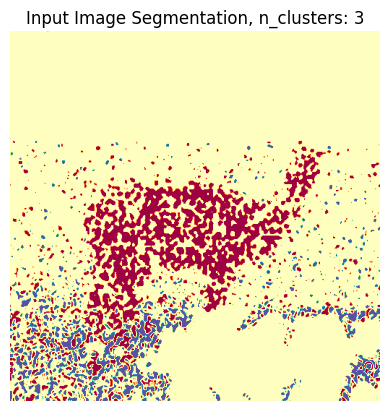

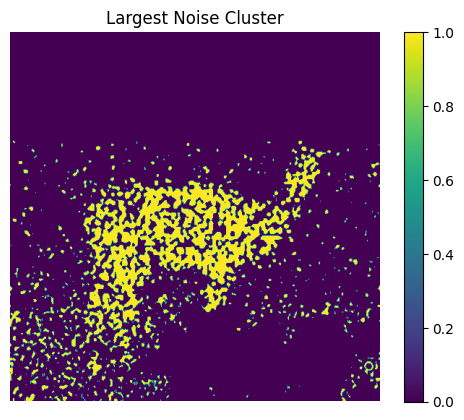

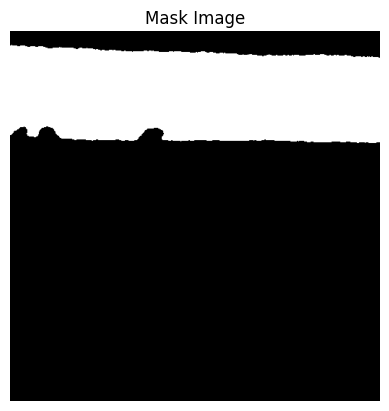

Real Vars:  [1.93302940e-05 2.24645059e-05 2.58046854e-04 9.51149746e-05
 4.56282108e-05 5.30325040e-05]
Imag Vars:  [8.12481127e-05 2.78134282e-05 9.24430710e-05 1.63331239e-05
 2.41354150e-05 2.36850370e-05]
Picked Bands:
No bands available. Adjust threshold maybe.
No bands available. Adjust threshold maybe.


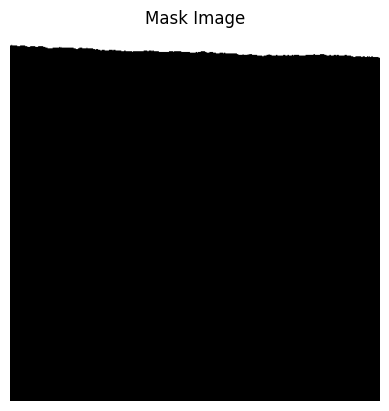

Real Vars:  [7.04675927e-06 1.36504756e-05 5.83018438e-05 2.22618272e-05
 1.98722943e-05 2.52263076e-05]
Imag Vars:  [3.44741245e-05 1.57755776e-05 2.15745751e-05 2.14162320e-06
 1.44132737e-05 8.92754590e-06]
Picked Bands:
No bands available. Adjust threshold maybe.
No bands available. Adjust threshold maybe.


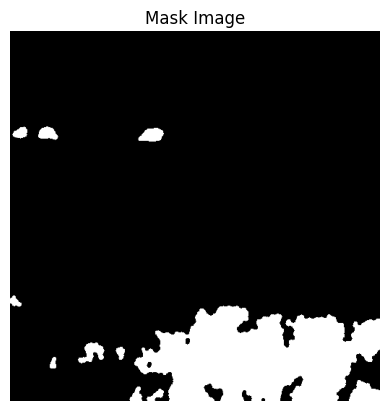

Real Vars:  [1.90148995e-04 7.53919229e-05 3.99010943e-04 5.27588207e-04
 1.45464117e-04 1.59524212e-04]
Imag Vars:  [2.48551855e-04 6.91817034e-05 4.63993273e-04 4.86250338e-04
 7.83730695e-05 1.55291607e-04]
Picked Bands:
No bands available. Adjust threshold maybe.
No bands available. Adjust threshold maybe.


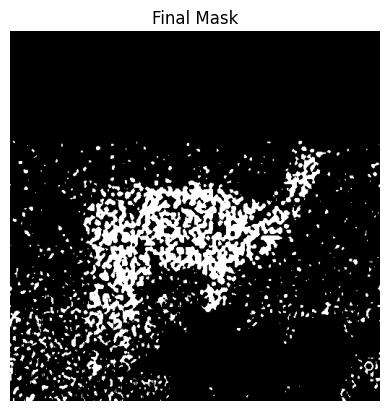

In [146]:
final_mask = detect_inpainting(file_path="../project/data/lama.bmp", wavelet_type='dtcwt', noise_func=noise_zero, kernel_size=5, patch_size=64, var_threshold='dynamic', display=True)

In [147]:
print("Final Mask: ", final_mask)

Final Mask:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [148]:
# save the mask as png file8)
# final_mask = final_mask/np.max(final_mask)
# final_mask = final_mask * 255
# final_mask = final_mask.astype(np.uint8)
# final_mask = Image.fromarray(final_mask)
# final_mask.save("mask_1.jpg")

In [149]:
print(final_mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


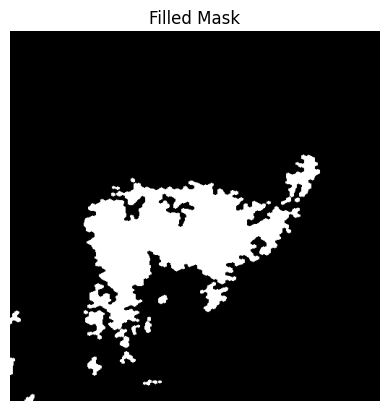

In [151]:
def morph_mask(mask):
    # use cv2 to fill the holes
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # do opening and closing to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # remove big connected components from the white mask
    mask = morphology.remove_small_objects(mask > 0, min_size=64, connectivity=1).astype(np.uint8)

    # invert the mask and remove small connected components from the black mask and invert it back
    mask = 1 - mask
    mask = morphology.remove_small_objects(mask > 0, min_size=512, connectivity=1).astype(np.uint8)
    mask = 1 - mask

    # open the mask to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    return mask


mask = morph_mask(final_mask)
plt.imshow(mask, cmap="gray")
plt.axis('off')
plt.title("Filled Mask")
plt.show()

# Metrics

In [ ]:
import numpy as np

def calculate_metrics(gt_mask, pred_mask):
    # convert predicted mask to numpy array
    pred_mask = np.array(pred_mask)
    
    # Ensure both masks have the same shape
    if gt_mask.shape != pred_mask.shape:
        raise ValueError("Ground truth and predicted masks must have the same shape.")
    
    # Convert masks to boolean arrays
    gt_mask_bool = gt_mask.astype(bool)
    pred_mask_bool = pred_mask.astype(bool)
    
    # Calculate the intersection and union
    intersection = np.logical_and(gt_mask_bool, pred_mask_bool)
    union = np.logical_or(gt_mask_bool, pred_mask_bool)
    
    # Calculate the IoU, handling division by zero
    union_sum = np.sum(union)
    if union_sum == 0:
        # If both masks are empty, define IoU as 1.0
        iou = 1.0
    else:
        iou = np.sum(intersection) / union_sum
    
    # Calculate the accuracy
    accuracy = np.mean(gt_mask_bool == pred_mask_bool)
    
    return accuracy, iou


In [ ]:
# get the ground truth mask
gt_mask = read_img("../project/data/md_0_paper_lama_mask.png")
print(gt_mask)

# downsample the ground truth mask to match the predicted mask size
gt_mask = gt_mask[::2, ::2]
gt_mask = gt_mask.mean(axis=2)

final_mask = np.array(final_mask)
#pad the mask to make it equal to the size of the bands
pad_x = (final_mask.shape[0] - gt_mask.shape[0])
pad_y = (final_mask.shape[1] - gt_mask.shape[1])
gt_mask = np.pad(gt_mask, ((pad_x//2, pad_x-(pad_x//2)), (pad_y//2, pad_y-(pad_y//2))), 'constant', constant_values=(0, 0))

print("Ground Truth Mask Shape: ", gt_mask.shape)

# print the ground truth mask
plt.imshow(gt_mask, cmap="gray")
plt.axis('off')
plt.title("Ground Truth Mask")
plt.show()

# calculate the quality metrics
accuracy, iou = calculate_metrics(gt_mask, final_mask)
print(f"Accuracy: {accuracy:.4f}")
print(f"IoU: {iou:.4f}")


# Experiments

In [ ]:
import os
def calculate_overall_metrics(data_dir, wavelet_type, noise_func, kernel_size=3, patch_size=16, var_threshold=0.005):
    files = [f for f in os.listdir(data_dir) if f.endswith(".bmp")]
    
    accuracies = []
    ious = []
    
    for file in files:
        file_path = os.path.join(data_dir, file)
        
        pred_mask = detect_inpainting(file_path, wavelet_type, noise_func, kernel_size, patch_size, var_threshold)
        
        gt_mask = read_img(file_path.replace(".bmp", "_mask.png"))
        gt_mask = gt_mask[::2, ::2]
        gt_mask = gt_mask.mean(axis=2)
        
        accuracy, iou = calculate_metrics(gt_mask, pred_mask)
        
        accuracies.append(accuracy)
        ious.append(iou)
    
    overall_accuracy = np.mean(accuracies)
    overall_iou = np.mean(ious)
    
    return overall_accuracy, overall_iou

In [ ]:
data_dir = "../project/data/test"
overall_accuracy, overall_iou = calculate_overall_metrics(data_dir, wavelet_type='dtcwt', noise_func=noise_zero, kernel_size=3, patch_size=16, var_threshold=0.005)
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall IoU: {overall_iou:.4f}")

## Testing

In [ ]:
print(read_img("../project/data/test.png"))